#**Практическое задание №1**

Установка необходимых пакетов:

In [1]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown
!pip install timm
!pip install torch torchvision

Монтирование Вашего Google Drive к текущему окружению:

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [3]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1jOG54j1f2-f-fcbuv89Wzn_wX-wTrR9I',
    'train_small': '1fYTCskVYCXUnQntQg1xpqEfYIcSuoEBA',
    'train_tiny': '17V3ly7zCNSK819GLhqvlENDgbFowJXgQ',
    'test': '1YwpLnEdftoAOH_C9ti61IPxEzYK8tMyx',
    'test_small': '1ovOfxHc4lxRs3MSSXV2tu6LnYOBQE1Ay',
    'test_tiny': '1eAyZ9oUQeg_E887gNQNaK2x81EGIVTXK'
}
'''
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}'''

"\n    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',\n    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',\n    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',\n    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',\n    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',\n    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'\n}"

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        file_id = DATASETS_LINKS[name]
        url = f"https://drive.google.com/uc?export=download&id={file_id}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)

        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz', allow_pickle=True)

        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From (original): https://drive.google.com/uc?export=download&id=17V3ly7zCNSK819GLhqvlENDgbFowJXgQ
From (redirected): https://drive.google.com/uc?export=download&id=17V3ly7zCNSK819GLhqvlENDgbFowJXgQ&confirm=t&uuid=663de9dd-cb27-49f5-a9ec-65fa50b6a8db
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:03<00:00, 27.6MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 5.
Label code corresponds to MUS class.


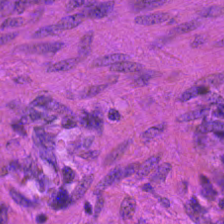

In [6]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

### Обёртка над Dataset для использования с PyTorch

In [7]:
# ============================================================
# (Опционально) Обёртка над Dataset для использования с PyTorch
# ============================================================

# ВНИМАНИЕ:
# Этот код нужен только тем, кто хочет решать задание с помощью PyTorch.
# Он показывает, как "подключить" наш Dataset к torch.utils.data.DataLoader.

try:
    import torch
    from torch.utils.data import Dataset as TorchDataset, DataLoader
    import torchvision.transforms as T
    from PIL import Image

    class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor
            return img, label

except ImportError:
    HistologyTorchDataset = None
    print("PyTorch / torchvision не найдены. Обёртка HistologyTorchDataset недоступна.")

### Пример использвания класса HistologyTorchDataset

In [8]:
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))


Пример использования PyTorch-обёртки над Dataset


Downloading...
From (original): https://drive.google.com/uc?export=download&id=17V3ly7zCNSK819GLhqvlENDgbFowJXgQ
From (redirected): https://drive.google.com/uc?export=download&id=17V3ly7zCNSK819GLhqvlENDgbFowJXgQ&confirm=t&uuid=5617145a-e8d9-4de8-a106-bd31f7b26863
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:02<00:00, 47.2MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Форма батча изображений: (8, 3, 224, 224)
Форма батча меток: (8,)
Пример меток: [0, 8, 8, 3, 3, 1, 1, 8]
Тип images_batch: <class 'torch.Tensor'>
Тип labels_batch: <class 'torch.Tensor'>


---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [9]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import json
from datetime import datetime
from tqdm.notebook import tqdm
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class Model:

    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_classes = len(TISSUE_CLASSES)
        self.model = None
        self._setup_model()
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': []
        }

    def _setup_model(self):
        self.model = timm.create_model(
            'efficientnet_b0',
            pretrained=True,
            num_classes=self.num_classes
        )
        self.model = self.model.to(self.device)

        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.test_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def save(self, name: str):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'history': self.history,
            'num_classes': self.num_classes
        }, f'/content/drive/MyDrive/{name}.pth')
        print(f"Модель сохранена как {name}.pth")

    def load(self, name: str):
        checkpoint = torch.load(f'/content/drive/MyDrive/{name}.pth',
                              map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.history = checkpoint.get('history', self.history)
        print(f"Модель загружена из {name}.pth")

    def train(self, dataset: Dataset, epochs=12, validation_split=0.2):

        print(f"Начало обучения")

        # Создаем PyTorch датасеты
        train_dataset = HistologyTorchDataset(dataset, transform=self.train_transform)

        # Разделение на train/val
        dataset_size = len(train_dataset)
        val_size = int(validation_split * dataset_size)
        train_size = dataset_size - val_size

        train_subset, val_subset = torch.utils.data.random_split(
            train_dataset, [train_size, val_size]
        )

        # DataLoader'ы
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2)

        # Оптимизатор и функция потерь
        optimizer = optim.AdamW(self.model.parameters(), lr=3e-4, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        best_val_acc = 0
        patience = 5
        patience_counter = 0

        for epoch in range(epochs):
            # Обучение
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            train_progress = tqdm(train_loader, desc=f'Обучение',
                                  bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')

            for batch_idx, (data, target) in enumerate(train_progress):
                data, target = data.to(self.device), target.to(self.device)

                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = output.max(1)
                train_total += target.size(0)
                train_correct += predicted.eq(target).sum().item()

                current_train_loss = train_loss / (batch_idx + 1)
                current_train_acc = 100. * train_correct / train_total

                # Обновляем описание прогресс-бара
                train_progress.set_postfix({
                    'Loss': f'{current_train_loss:.4f}',
                    'Acc': f'{current_train_acc:.2f}%',
                    'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
                })

            train_acc = 100. * train_correct / train_total
            train_loss = train_loss / len(train_loader)
            print(f"Loss: {train_loss:.4f}")
            print(f"Acc: {train_acc:.2f}%")

            # Валидация
            val_loss, val_acc = self._validate(val_loader, criterion)

            # Обновление scheduler
            scheduler.step()

            # Сохранение истории
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f'Epoch {epoch+1}/{epochs}:')
            print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                self.save('best')
                #print(f'Новый лучший результат!')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping на эпохе {epoch+1}')
                break

        # Визуализация результатов обучения
        self._plot_training_history()
        print(f"Обучение завершено!")

    def _validate(self, val_loader, criterion):
        self.model.eval()
        val_loss = 0
        correct = 0
        total = 0

        val_progress = tqdm(val_loader, desc=f'Валидация',
                           bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}')

        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_progress):
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

                current_val_loss = val_loss / (batch_idx + 1)
                current_val_acc = 100. * correct / total

                val_progress.set_postfix({
                    'Loss': f'{current_val_loss:.4f}',
                    'Acc': f'{current_val_acc:.2f}%'
                })

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total
        return val_loss, val_acc

    def _plot_training_history(self):
        if not self.history['train_loss']:
            print("Нет данных для визуализации")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # График потерь
        ax1.plot(self.history['train_loss'], label='Train Loss', marker='o')
        ax1.plot(self.history['val_loss'], label='Val Loss', marker='o')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # График точности
        ax2.plot(self.history['train_acc'], label='Train Accuracy', marker='o')
        ax2.plot(self.history['val_acc'], label='Val Accuracy', marker='o')
        ax2.set_title('Training and Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def test_on_dataset(self, dataset: Dataset, limit=None):
        self.model.eval()
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)

        # Используем последовательный доступ к изображениям
        for i, img in tqdm(enumerate(dataset.images_seq(n)), total=n, desc="Тестирование"):
            if i >= n:
                break
            prediction = self.test_on_image(img)
            predictions.append(prediction)

        return predictions

    def test_on_image(self, img: np.ndarray):
        self.model.eval()

        # Преобразуем numpy array в PIL Image и применяем трансформации
        pil_img = Image.fromarray(img)
        input_tensor = self.test_transform(pil_img).unsqueeze(0).to(self.device)

        with torch.no_grad():
            output = self.model(input_tensor)
            _, prediction = torch.max(output, 1)

        return prediction.item()

    def plot_confusion_matrix(self, true_labels, predictions, dataset_name=""):
        cm = confusion_matrix(true_labels, predictions)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=TISSUE_CLASSES,
                   yticklabels=TISSUE_CLASSES)
        plt.title(f'Матрица ошибок')
        plt.xlabel('Предсказанные классы')
        plt.ylabel('Истинные классы')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        return cm

---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [11]:
d_train = Dataset('train')
d_test = Dataset('test')

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1jOG54j1f2-f-fcbuv89Wzn_wX-wTrR9I
From (redirected): https://drive.google.com/uc?export=download&id=1jOG54j1f2-f-fcbuv89Wzn_wX-wTrR9I&confirm=t&uuid=c5efeb03-b34c-4855-866e-3e97c5592058
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:40<00:00, 51.7MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1YwpLnEdftoAOH_C9ti61IPxEzYK8tMyx
From (redirected): https://drive.google.com/uc?export=download&id=1YwpLnEdftoAOH_C9ti61IPxEzYK8tMyx&confirm=t&uuid=139798de-8ff9-4599-baa6-efb8e126ab79
To: /content/test.npz
100%|██████████| 525M/525M [00:10<00:00, 51.7MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Начало обучения


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.4397
Acc: 87.09%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 1/12:
  Train Loss: 0.4397, Train Acc: 87.09%
  Val Loss: 0.1743, Val Acc: 94.75%
  LR: 0.000295
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.1988
Acc: 93.58%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 2/12:
  Train Loss: 0.1988, Train Acc: 93.58%
  Val Loss: 0.1532, Val Acc: 95.33%
  LR: 0.000280
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.1574
Acc: 95.08%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 3/12:
  Train Loss: 0.1574, Train Acc: 95.08%
  Val Loss: 0.1079, Val Acc: 96.47%
  LR: 0.000256
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.1246
Acc: 96.07%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 4/12:
  Train Loss: 0.1246, Train Acc: 96.07%
  Val Loss: 0.1090, Val Acc: 96.50%
  LR: 0.000225
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.1117
Acc: 96.43%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 5/12:
  Train Loss: 0.1117, Train Acc: 96.43%
  Val Loss: 0.0844, Val Acc: 97.58%
  LR: 0.000189
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.0900
Acc: 97.08%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 6/12:
  Train Loss: 0.0900, Train Acc: 97.08%
  Val Loss: 0.0800, Val Acc: 97.69%
  LR: 0.000150
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.0730
Acc: 97.42%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 7/12:
  Train Loss: 0.0730, Train Acc: 97.42%
  Val Loss: 0.0765, Val Acc: 97.58%
  LR: 0.000111


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.0593
Acc: 97.92%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 8/12:
  Train Loss: 0.0593, Train Acc: 97.92%
  Val Loss: 0.0728, Val Acc: 98.11%
  LR: 0.000075
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.0460
Acc: 98.37%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 9/12:
  Train Loss: 0.0460, Train Acc: 98.37%
  Val Loss: 0.0596, Val Acc: 98.28%
  LR: 0.000044
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.0434
Acc: 98.49%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 10/12:
  Train Loss: 0.0434, Train Acc: 98.49%
  Val Loss: 0.0475, Val Acc: 98.42%
  LR: 0.000020
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.0427
Acc: 98.53%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 11/12:
  Train Loss: 0.0427, Train Acc: 98.53%
  Val Loss: 0.0451, Val Acc: 98.56%
  LR: 0.000005
Модель сохранена как best.pth


Обучение:   0%|                              | 0/450 [00:00<?, ?it/s]

Loss: 0.0346
Acc: 98.90%


Валидация:   0%|                              | 0/113 [00:00<?, ?it/s]

Epoch 12/12:
  Train Loss: 0.0346, Train Acc: 98.90%
  Val Loss: 0.0485, Val Acc: 98.58%
  LR: 0.000000
Модель сохранена как best.pth


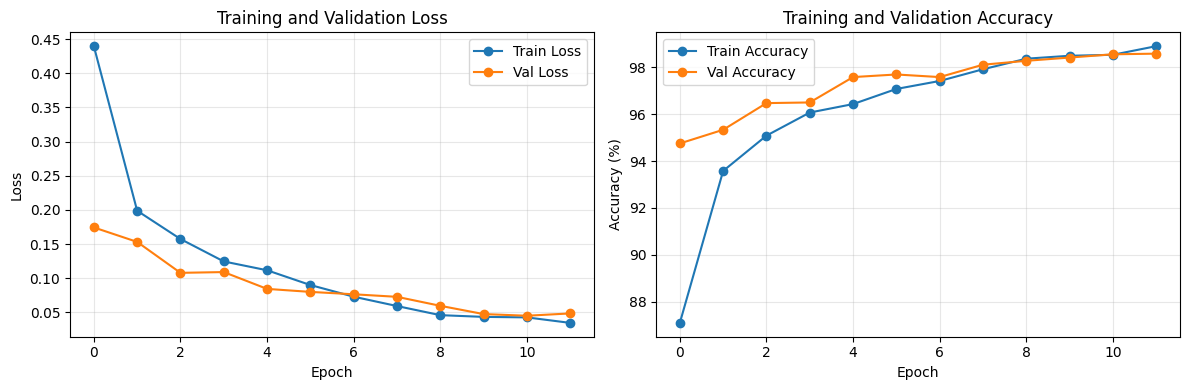

Обучение завершено!
Модель сохранена как best.pth


In [12]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    #todo: your link goes here
    #https://drive.google.com/file/d/1oNEIYyYd7oyXnU0WzYkulNe3PtCYBO3K/view?usp=sharing
    model.load('best')

Пример тестирования модели на части набора данных:

Тестирование:   0%|          | 0/450 [00:00<?, ?it/s]

metrics for 10% of test:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


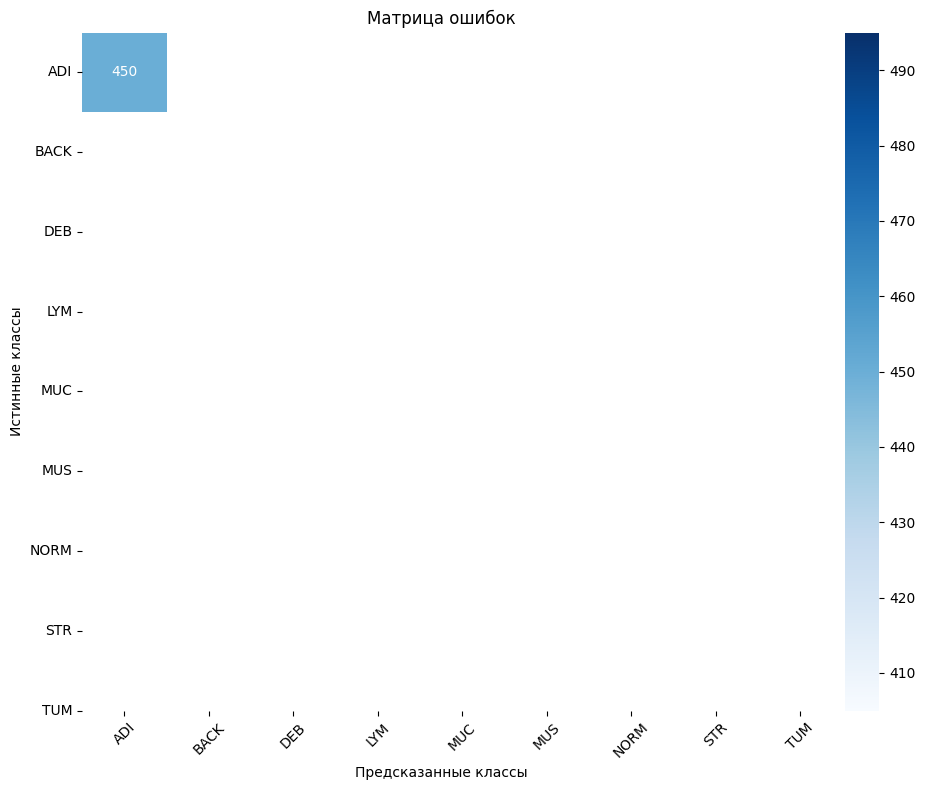

array([[450]])

In [13]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')
true_labels_10percent = d_test.labels[:len(pred_1)]
model.plot_confusion_matrix(true_labels_10percent, pred_1)

Пример тестирования модели на полном наборе данных:

Тестирование:   0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test:
	 accuracy 0.9916:
	 balanced accuracy 0.9916:


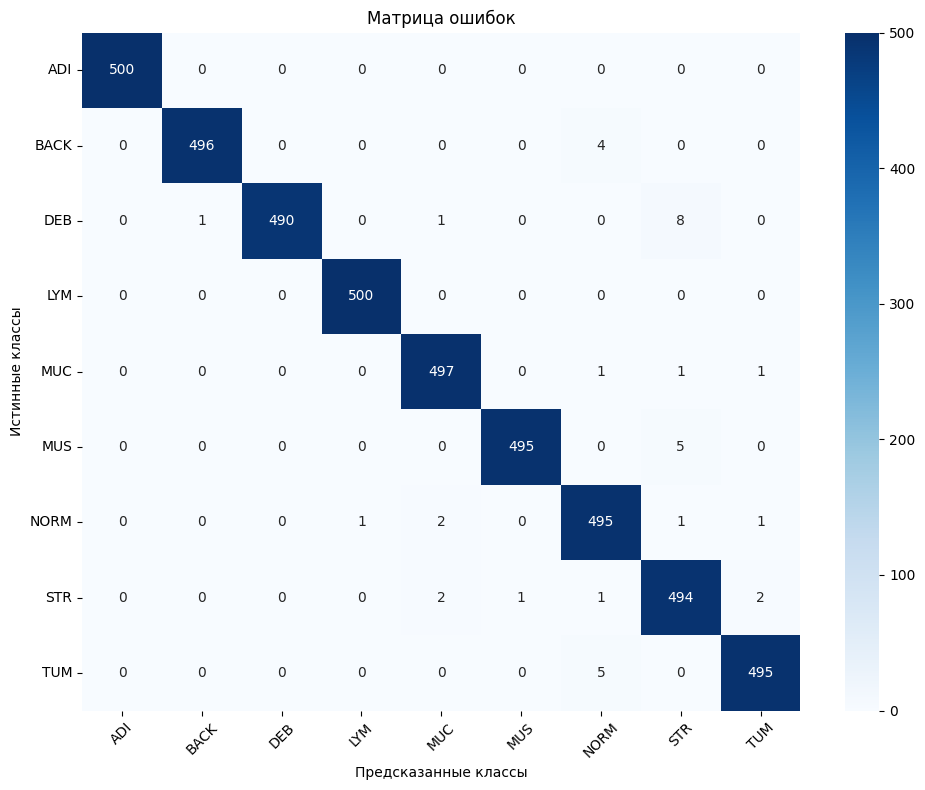

In [14]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')
    true_labels_10percent = d_test.labels[:len(pred_2)]
    model.plot_confusion_matrix(true_labels_10percent, pred_2)


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [15]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Модель загружена из best.pth


Downloading...
From: https://drive.google.com/uc?export=download&id=1eAyZ9oUQeg_E887gNQNaK2x81EGIVTXK
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 30.9MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


Тестирование:   0%|          | 0/90 [00:00<?, ?it/s]

metrics for test-tiny:
	 accuracy 1.0000:
	 balanced accuracy 1.0000:


Отмонтировать Google Drive.

In [16]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [17]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

Function f is caluclated 128 times in 0.02822809799999959s.


### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




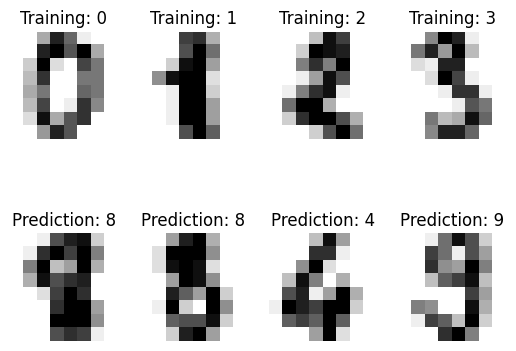

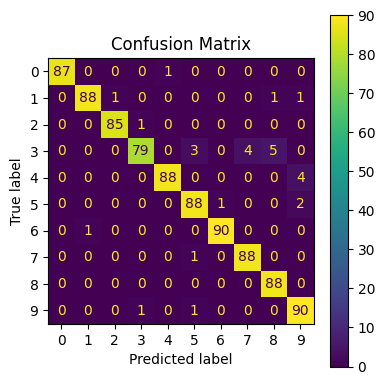

In [18]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

# Матрица ошибок + визуализация в новом API
cm = metrics.confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classifier.classes_)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

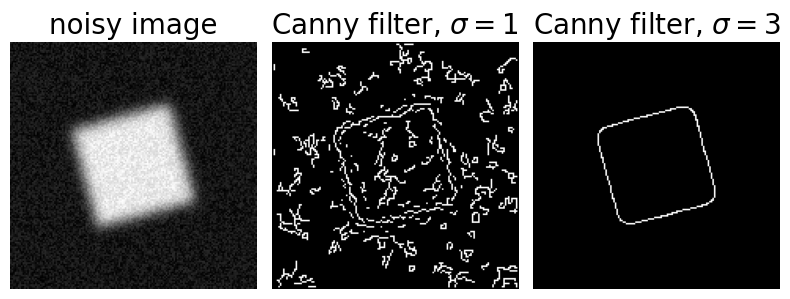

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [20]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

KeyboardInterrupt: 

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### PyTorch

In [ ]:
# ============================================================
# Дополнительно: мини-демо PyTorch
# ============================================================
# Ранний выход, если PyTorch/обёртка недоступны
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import DataLoader
except ImportError:
    print("PyTorch не установлен — демо пропущено.")
    import sys
    raise SystemExit

if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("HistologyTorchDataset недоступна — демо пропущено.")
    import sys
    raise SystemExit


# --- Данные: tiny-наборы, чтобы выполнялось быстро ---
base_train = Dataset('train_tiny')
base_test  = Dataset('test_tiny')

train_ds = HistologyTorchDataset(base_train)           # ToTensor по умолчанию
test_ds  = HistologyTorchDataset(base_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# --- Мини-модель: двухслойный CNN + один FC (демонстрация, не решение) ---
class TinyCNN(nn.Module):
    def __init__(self, num_classes=len(TISSUE_CLASSES)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)  # 224->112->56
        self.fc    = nn.Linear(16 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 3, 224, 224] -> [B, 8, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 112, 112] -> [B, 16, 56, 56]
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = TinyCNN(num_classes=len(TISSUE_CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Один учебный шаг "обучения" на одном батче ---
model.train()
xb, yb = next(iter(train_loader))
xb = xb.to(device)
yb = yb.to(device, dtype=torch.long)

optimizer.zero_grad()
logits = model(xb)
loss = criterion(logits, yb)
float_loss = float(loss.detach().cpu())
loss.backward()
optimizer.step()

print(f"Loss на одном батче train_tiny: {float_loss:.4f}")

# --- Быстрая проверка на одном батче теста (для формы вывода/метрик) ---
model.eval()
with torch.no_grad():
    xt, yt = next(iter(test_loader))
    xt = xt.to(device)
    logits_t = model(xt).cpu()
    y_pred = logits_t.argmax(dim=1).numpy()
    y_true = yt.numpy()

print("Размерности:", {"y_true": y_true.shape, "y_pred": y_pred.shape})
Metrics.print_all(y_true, y_pred, "_")  # balanced accuracy/accuracy на одном батче для демонстрации

# для полноценного решения требуется собственный тренировочный цикл по эпохам,
# аугментации/нормализация, сохранение/загрузка весов, и тестирование на всём наборе.

### Дополнительные ресурсы по PyTorch

- **Официальные туториалы PyTorch** — https://pytorch.org/tutorials/  
- **“Deep Learning with PyTorch: 60-Minute Blitz”** — https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
- **Transfer Learning for Computer Vision** — https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
- **PyTorch Get Started (установка)** — https://pytorch.org/get-started/locally/  
- **Dive into Deep Learning (D2L, глава PyTorch)** — https://d2l.ai/chapter_preliminaries/index.html  
- **Fast.ai — Practical Deep Learning for Coders** — https://course.fast.ai/  
- **Learn PyTorch.io (Zero to Mastery)** — https://www.learnpytorch.io/

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"